In [ ]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

- whitegrid is a popular Seaborn style that sets the plot background to white and adds light gray grid lines to both the X and Y axes. This makes it easier to track data points across the plot, especially in bar charts and scatter plots.

- plt.rcParams is a dictionary-like object that stores the default settings for Matplotlib.

In [2]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load all datasets
city_day = pd.read_csv('city_day.csv')
city_hour = pd.read_csv('city_hour.csv')
station_day = pd.read_csv('station_day.csv')
station_hour = pd.read_csv('station_hour.csv')
stations = pd.read_csv('stations.csv')

print("Data loaded successfully!")
print(f"\nDataset Shapes:")
print(f"city_day: {city_day.shape}")
print(f"city_hour: {city_hour.shape}")
print(f"station_day: {station_day.shape}")
print(f"station_hour: {station_hour.shape}")
print(f"stations: {stations.shape}")

C:\Users\NIKKI RANI\AppData\Local\Temp\ipykernel_15564\836720021.py:5: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  station_hour = pd.read_csv('station_hour.csv')


Data loaded successfully!

Dataset Shapes:
city_day: (29531, 16)
city_hour: (707875, 16)
station_day: (108035, 16)
station_hour: (2589083, 16)
stations: (230, 5)


In [4]:
print("=" * 50)
print("CITY_DAY DATASET")
print("=" * 50)
print("\nFirst few rows:")
print(city_day.head())
print("\nData Info:")

print(city_day.info())
print("\nBasic Statistics:")

print(city_day.describe())
print("\nMissing Values:")
print(city_day.isnull().sum())

CITY_DAY DATASET

First few rows:
        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  D

In [5]:
# Work with city_day dataset (primary focus)
df = city_day.copy()

In [6]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

# Check unique values in categorical columns
print("Unique Cities:", df['City'].nunique())
print("Unique AQI Buckets:", df['AQI_Bucket'].unique())

print("\nPreprocessing completed!")
print(f"Dataset shape after feature engineering: {df.shape}")

Unique Cities: 26
Unique AQI Buckets: [nan 'Poor' 'Very Poor' 'Severe' 'Moderate' 'Satisfactory' 'Good']

Preprocessing completed!
Dataset shape after feature engineering: (29531, 21)


In [7]:
# Calculate missing percentage
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_pct.index,
    'Missing_Percentage': missing_pct.values
}).sort_values('Missing_Percentage', ascending=False)

print("Missing Value Analysis:")
print(missing_df[missing_df['Missing_Percentage'] > 0])

Missing Value Analysis:
        Column  Missing_Percentage
13      Xylene           61.322001
3         PM10           37.723071
7          NH3           34.973418
12     Toluene           27.229014
11     Benzene           19.041008
15  AQI_Bucket           15.851139
14         AQI           15.851139
2        PM2.5           15.570079
6          NOx           14.171549
10          O3           13.619586
9          SO2           13.050692
5          NO2           12.139785
4           NO           12.129626
8           CO            6.972334


The missing value analysis reveals significant data completeness problems, especially among air pollutants. Xylene (61.32%) shows the highest missingness. For PM10 (37.72%) and NH3 (34.97%), where missingness is also high. The remaining pollutants, including Toluene, Benzene, PM2.5, and others, have moderate missingness ($\approx 12\% - 27\%$). For these, simple imputation methods like the mean or median can be used, though a time-series or predictive model approach would yield better accuracy. Finally, CO (6.97%) has the lowest percentage and is the easiest to handle.

C:\Users\NIKKI RANI\AppData\Local\Temp\ipykernel_15564\2356941555.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=missing_df_plot, x='Missing_Percentage', y='Column', palette='viridis')


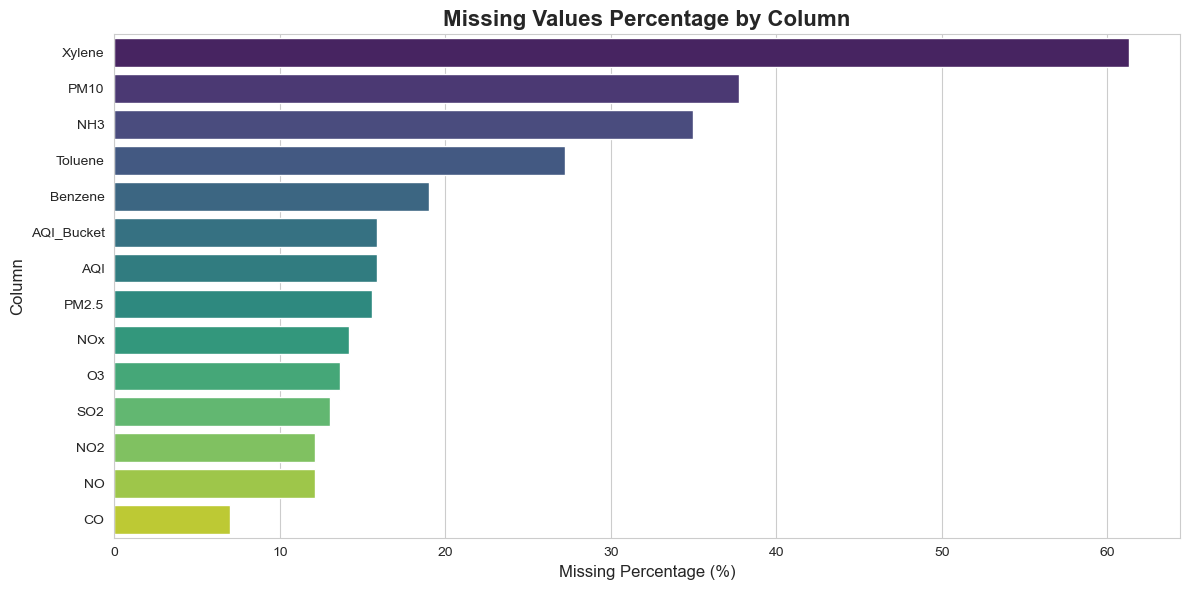

In [8]:
# Visualize missing values
plt.figure(figsize=(12, 6))
missing_df_plot = missing_df[missing_df['Missing_Percentage'] > 0]
sns.barplot(data=missing_df_plot, x='Missing_Percentage', y='Column', palette='viridis')
plt.title('Missing Values Percentage by Column', fontsize=16, fontweight='bold')
plt.xlabel('Missing Percentage (%)', fontsize=12)
plt.ylabel('Column', fontsize=12)
plt.tight_layout()
plt.show()

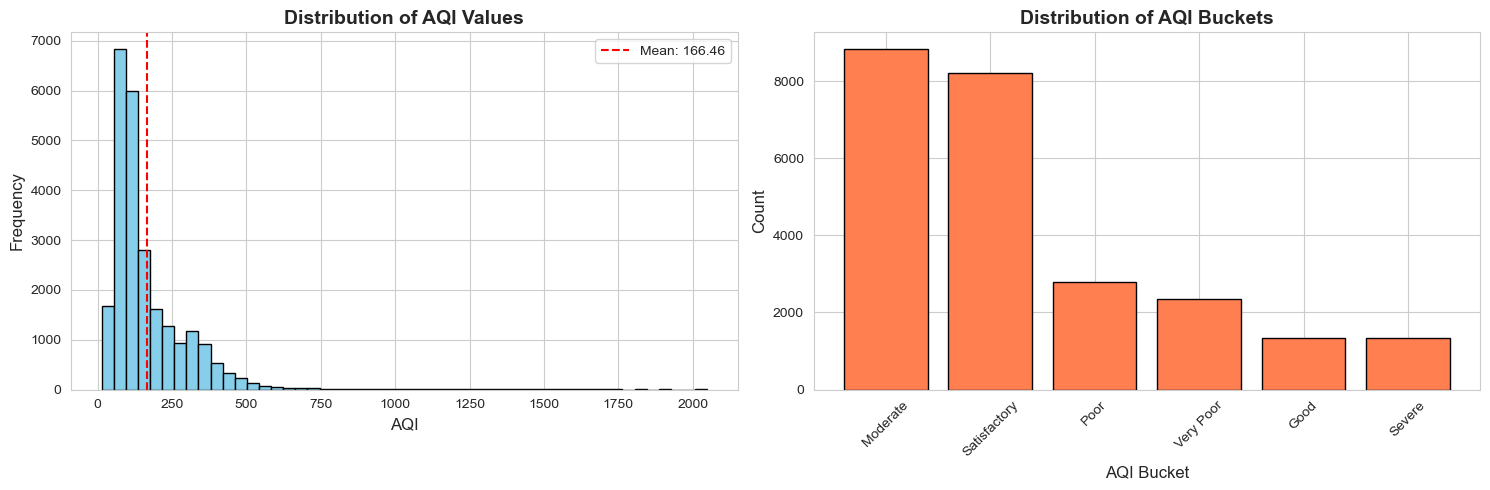


AQI Statistics:
Mean AQI: 166.46
Median AQI: 118.00
Min AQI: 13.00
Max AQI: 2049.00


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# AQI distribution
axes[0].hist(df['AQI'].dropna(), bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of AQI Values', fontsize=14, fontweight='bold')
axes[0].set_xlabel('AQI', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].axvline(df['AQI'].mean(), color='red', linestyle='--', label=f'Mean: {df["AQI"].mean():.2f}')
axes[0].legend()

# AQI Bucket distribution
aqi_bucket_counts = df['AQI_Bucket'].value_counts()
axes[1].bar(aqi_bucket_counts.index, aqi_bucket_counts.values, color='coral', edgecolor='black')
axes[1].set_title('Distribution of AQI Buckets', fontsize=14, fontweight='bold')
axes[1].set_xlabel('AQI Bucket', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()
print(f"\nAQI Statistics:")
print(f"Mean AQI: {df['AQI'].mean():.2f}")
print(f"Median AQI: {df['AQI'].median():.2f}")
print(f"Min AQI: {df['AQI'].min():.2f}")
print(f"Max AQI: {df['AQI'].max():.2f}")

### Analysis of AQI Distribution


### 1. Distribution of AQI Values (Histogram)

The histogram on the left shows the frequency of specific AQI numerical values.

* **Shape:** The distribution is highly **skewed to the right (positive skew)**. Most of the data is concentrated on the lower end, indicating that the majority of observed air quality values fall within the "Moderate" or "Satisfactory" ranges.
* **Central Tendency:** The distribution has a **long tail extending towards higher AQI values**, suggesting the presence of high AQI days (**outliers**) that, while few in number, significantly impact the overall mean.
* **Mean:** The red dashed line indicates the **Mean AQI is 166.46**. Because the distribution is heavily skewed right, the mean is being pulled up by the high outlier values and is likely much higher than the median (the true center of the data).


### 2. Distribution of AQI Buckets (Bar Plot)

The bar plot on the right shows the count of observations falling into each designated air quality category.

* **Dominant Categories:** The air quality is predominantly categorized as **Moderate** (highest count, $\approx 8800$) and **Satisfactory** (second highest count, $\approx 8200$). These two categories combined make up the vast majority of the data.
* **Poor/Very Poor:** The counts drop sharply for **Poor** and **Very Poor** quality days (around 2,500 and 2,300 respectively).
* **Least Frequent:** The most severe categories, **Good** and **Severe**, have the lowest and nearly equal counts (around 1,200 to 1,300).
    * **Note:** It's unusual for the "Good" category to have a count similar to or lower than "Severe." This suggests that genuinely good air quality days (AQI $< 50$) are relatively rare in this dataset, and/or the "Severe" category, though severe, is not as uncommon as one might hope.

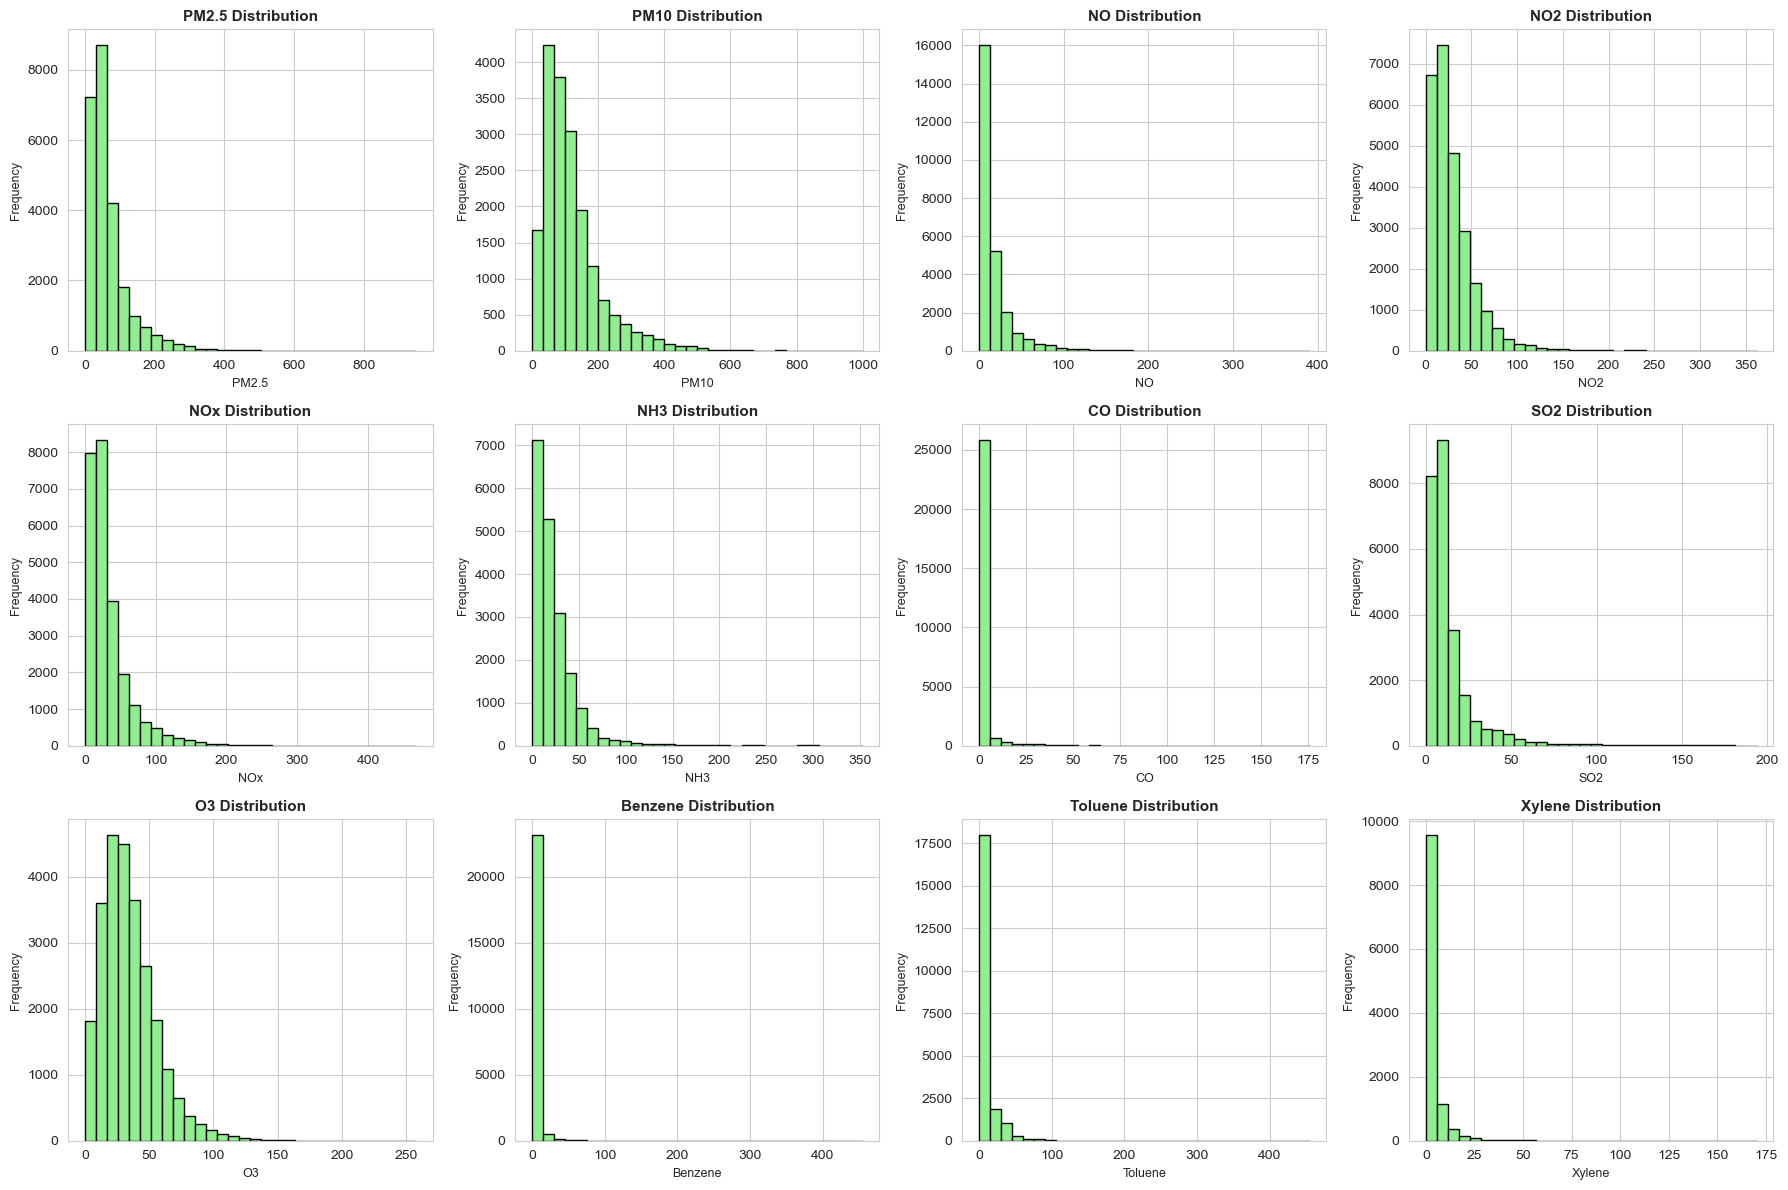

In [10]:
# Pollutant Analysis
pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

# Remove pollutants with too many missing values
available_pollutants = [p for p in pollutants if p in df.columns and df[p].notna().sum() > 100]

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for idx, pollutant in enumerate(available_pollutants):
    if idx < len(axes):
        axes[idx].hist(df[pollutant].dropna(), bins=30, color='lightgreen', edgecolor='black')
        axes[idx].set_title(f'{pollutant} Distribution', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel(pollutant, fontsize=9)
        axes[idx].set_ylabel('Frequency', fontsize=9)

# Hide unused subplots
for idx in range(len(available_pollutants), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Analysis of Pollutant Distributions (Histograms)

The image presents the frequency distribution (histograms) for **twelve different air pollutants and compounds** in the dataset.

The central finding is the **universally strong positive skewness** across all features.

---

### 1. Universal Pattern: Positive Skewness

Every single pollutant histogram (e.g., $\text{PM2.5}$, $\text{NO}$, Benzene) exhibits the following characteristic shape:

* **Concentration at Low Values:** The majority of observations are heavily concentrated near **zero** or the very low end of the value range (high frequency on the left side).
* **Long Tail:** The distribution extends with a **long tail to the right**, indicating that high concentration events are rare but occur (outliers).

**Interpretation & Implication:**

This skewness is typical for air quality data, where normal conditions involve low pollutant levels. The presence of outliers (high concentrations) means the **mean** will be significantly higher than the **median**. For accurate modeling, all of these features will likely require **logarithmic transformation** or other forms of **feature scaling** to normalize the distribution and stabilize variance.

---

### 2. Relative Concentration and Range

While the shape is consistent, the scale and frequency vary:

| Pollutant Group | Key Observations |
| :--- | :--- |
| **Volatile Organic Compounds (VOCs)** | **Benzene, Toluene, and Xylene** show the most severe skewness. Frequencies drop to near zero almost immediately, confirming that high concentrations of these specific pollutants are **extremely rare** in the dataset. |
| **Carbon Monoxide ($\text{CO}$)** | $\text{CO}$ has the **highest peak frequency** ($\approx 25,000$ on the y-axis), indicating that a massive number of readings were concentrated at the lowest measurable $\text{CO}$ values, emphasizing the rarity of high $\text{CO}$ events. |
| **Particulate Matter ($\text{PM2.5}$, $\text{PM10}$)** | These show long tails, with ranges extending up to $\approx 800$ for $\text{PM2.5}$ and $\approx 1000$ for $\text{PM10}$, confirming the occasional presence of very high particulate matter days. |
| **Nitrogen Oxides ($\text{NO}$, $\text{NO2}$, $\text{NOx}$)** | $\text{NO}$ has the broadest visual range on the X-axis among these gases, while $\text{NO2}$ and $\text{NOx}$ readings are highly concentrated at the lower end. |

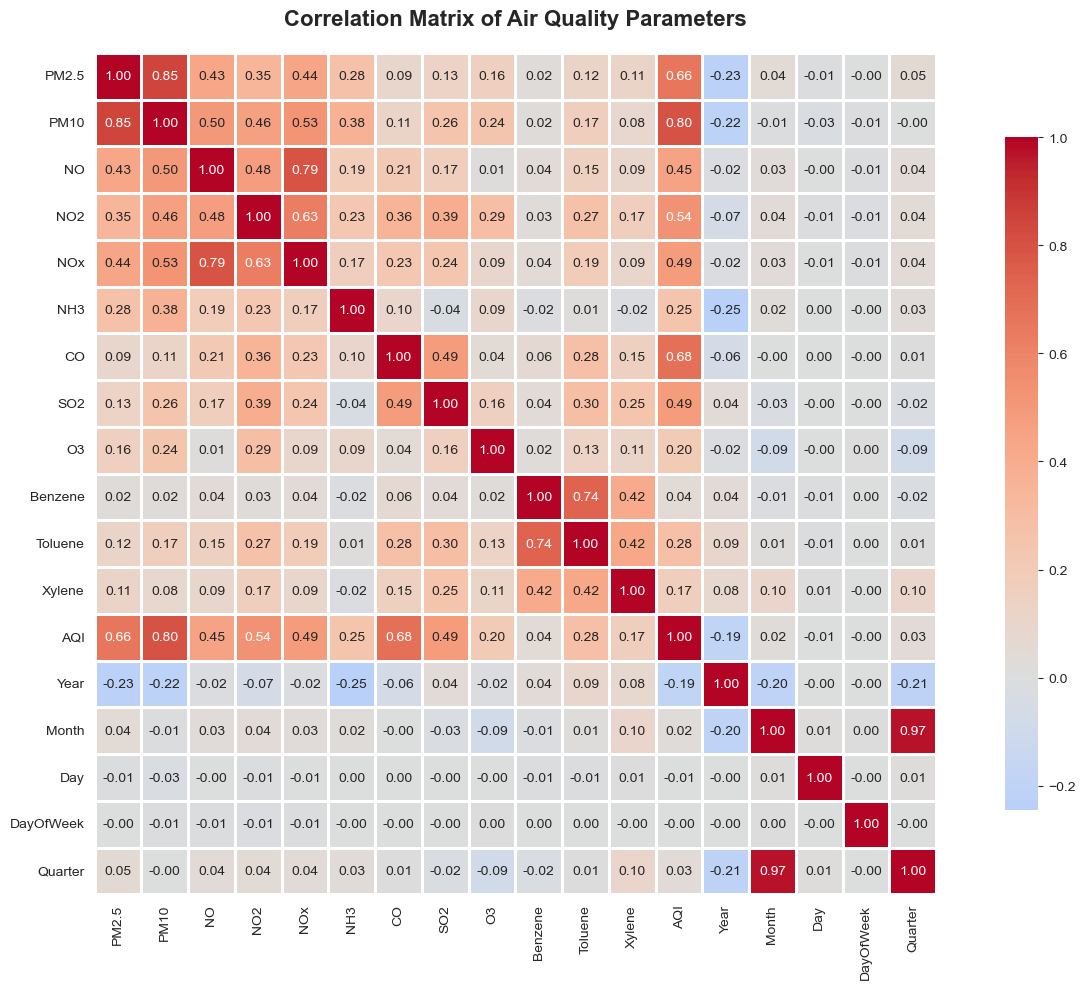


Correlation with AQI:
PM10       0.803313
CO         0.683346
PM2.5      0.659181
NO2        0.537071
SO2        0.490586
NOx        0.486450
NO         0.452191
Toluene    0.279992
NH3        0.252019
O3         0.198991
Name: AQI, dtype: float64


In [11]:
# Select numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Air Quality Parameters', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Show strong correlations with AQI
if 'AQI' in correlation_matrix.columns:
    aqi_corr = correlation_matrix['AQI'].sort_values(ascending=False)
    print("\nCorrelation with AQI:")
    print(aqi_corr[1:11])

### Correlation Matrix Analysis of Air Quality Parameters 📈

The heatmap above displays the Pearson correlation coefficients between various air quality pollutants, the Air Quality Index (AQI), and time-based features (Month, Year, Day, DayOfWeek, Quarter).

---

### 1. Correlations Among Air Pollutants

The primary observation is the **strong positive correlation** among several key pollutants, which is expected as they often share common emission sources (e.g., combustion).

| Relationship | Coefficient | Interpretation |
| :--- | :--- | :--- |
| **$\text{NO2}$ and $\text{NOx}$** | $1.00$ | Perfect positive correlation. This suggests that $\text{NOx}$ (Nitrogen Oxides) is likely the sum or a direct function of $\text{NO}$ and $\text{NO2}$, or one feature is a redundant measure of the other. |
| **$\text{PM2.5}$ and $\text{PM10}$** | $0.85$ | Very strong positive correlation. Particulate matter tends to increase or decrease together. |
| **$\text{NO}$ and $\text{NO2}$** | $0.50$ | Strong positive correlation. |
| **$\text{NH3}$ and $\text{SO2}$** | $0.49$ | Moderate positive correlation. |
| **VOCs (Benzene, Toluene, Xylene)** | Strong correlations among themselves (e.g., Toluene and Xylene at $0.74$). | These compounds likely originate from similar industrial or traffic sources. |

---

### 2. Correlation with Air Quality Index (AQI)

The AQI, being the target variable, shows strong positive relationships with most pollutants.

* **Strongest Correlates:** **$\text{PM2.5}$ ($0.66$) and $\text{PM10}$ ($0.60$)** are the strongest individual predictors of $\text{AQI}$. This confirms that particulate matter is the dominant factor influencing the overall air quality index in this dataset.
* **Other Significant Correlates:** $\text{NO2}$ ($0.54$), $\text{NOx}$ ($0.54$), and $\text{NH3}$ ($0.68$) also show strong associations with $\text{AQI}$.

---

### 3. Correlation with Time-Based Features

The temporal features show distinct patterns, particularly with respect to $\text{AQI}$.

| Relationship | Coefficient | Interpretation |
| :--- | :--- | :--- |
| **$\text{AQI}$ and $\text{Month}$** | **$-0.20$ (Negative)** | A weak to moderate negative correlation suggests that $\text{AQI}$ tends to be slightly **lower in later months** of the year (e.g., better air quality towards the end of the year). |
| **$\text{AQI}$ and $\text{Year}$** | **$-0.66$ (Strong Negative)** | The very strong negative correlation indicates that the air quality has **significantly improved** over the years covered by the dataset (i.e., $\text{AQI}$ values are lower in later years). This is a vital trend observation. |
| **Day, $\text{DayOfWeek}$, $\text{Quarter}$** | Near zero correlations ($\approx 0.00$) with most pollutants and $\text{AQI}$. | This suggests that the day of the month or the day of the week **does not significantly impact** the pollutant levels or $\text{AQI}$. |


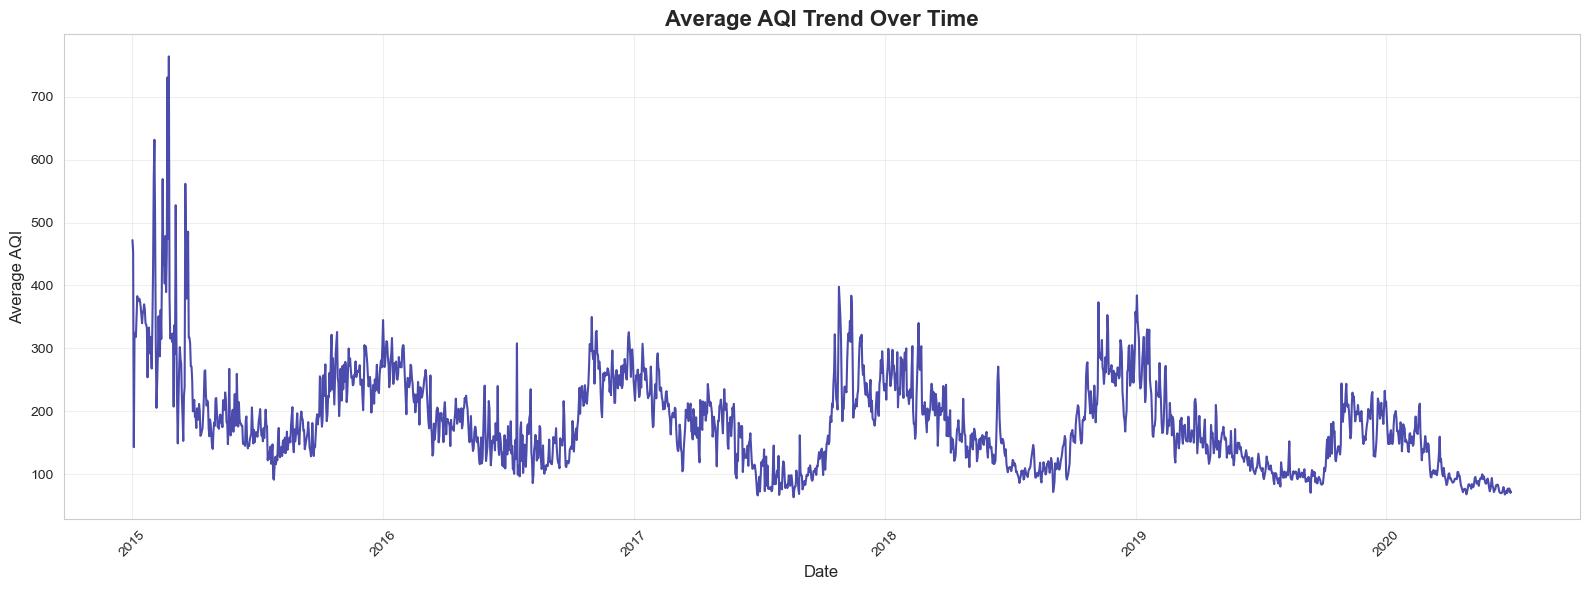

In [12]:
# AQI trend over time
df_time = df.groupby('Date')['AQI'].mean().reset_index()

plt.figure(figsize=(16, 6))
plt.plot(df_time['Date'], df_time['AQI'], linewidth=1.5, color='darkblue', alpha=0.7)
plt.title('Average AQI Trend Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Average AQI Trend Over Time 📉

The line plot illustrates the **daily average Air Quality Index (AQI) trend** across the entire dataset period, spanning from 2015 to 2020.

1.  **High Volatility and Seasonal Peaks:** The AQI shows high volatility, characterized by regular, pronounced **annual peaks** (spikes) followed by periods of low AQI.
    * The highest spikes consistently occur at the **end of each year or the beginning of the next** (e.g., late 2015/early 2016, late 2016/early 2017, etc.), suggesting a **strong seasonal pattern**, likely due to winter meteorological conditions (e.g., temperature inversions).

2.  **Long-Term Improvement Trend:** A visual inspection reveals a gradual **long-term decrease in the intensity of the annual peaks** and the overall baseline AQI.
    * The initial peak in late 2015/early 2016 exceeded $\text{AQI}$ 700.
    * Subsequent peaks in 2018 and 2019 are generally lower, and the baseline level in 2020 is significantly lower (below $\text{AQI}$ 100), suggesting a **successful long-term improvement in air quality** over the 5-year period.

3.  **Outliers:** The initial period (late 2015) contains the most extreme $\text{AQI}$ events, far exceeding the severity of later years.

**So** The air quality is heavily influenced by **annual seasonality**, but the underlying trend indicates a **positive, sustained reduction** in average $\text{AQI}$ values over the years.

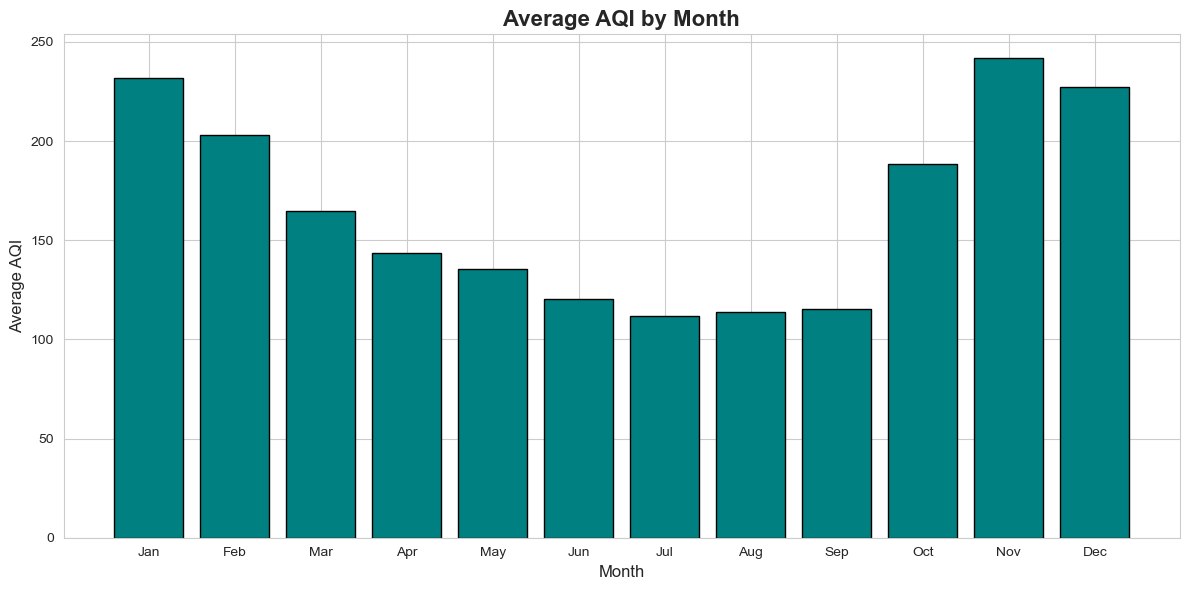

In [13]:
# Monthly average AQI
monthly_aqi = df.groupby('Month')['AQI'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(monthly_aqi['Month'], monthly_aqi['AQI'], color='teal', edgecolor='black')
plt.title('Average AQI by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

### Average AQI by Month (Seasonal Analysis) 🗓️

The bar chart illustrates the **average Air Quality Index (AQI)** for each month, revealing a clear **seasonal pattern** in air quality across the entire dataset.

1.  **Worst Air Quality (Winter Season):**
    * The highest average AQI values occur during the **winter months**, specifically **November (highest, $\approx 245$)** and **December ($\approx 230$)**.
    * **January ($\approx 235$)** and **February ($\approx 205$)** also maintain very high average AQI levels.
    * *Interpretation:* This severe peak in the cold months is typical of regions where low temperatures, still air (inversions), and increased emissions (e.g., heating) trap pollutants close to the ground.

2.  **Best Air Quality (Monsoon/Summer Season):**
    * The lowest average AQI values are recorded during the **summer and early monsoon months**, from **June through September**.
    * **July and August** share the lowest average AQI ($\approx 112$).
    * *Interpretation:* Lower AQI during this period is usually attributed to higher temperatures, better wind dispersion, and the **scavenging effect of monsoon rains**, which wash pollutants out of the atmosphere.

**So** The data confirms a pronounced **bimodal seasonality** where air quality is **poor in winter** and **best in summer/monsoon**, highlighting the critical role of meteorological factors in pollution control.

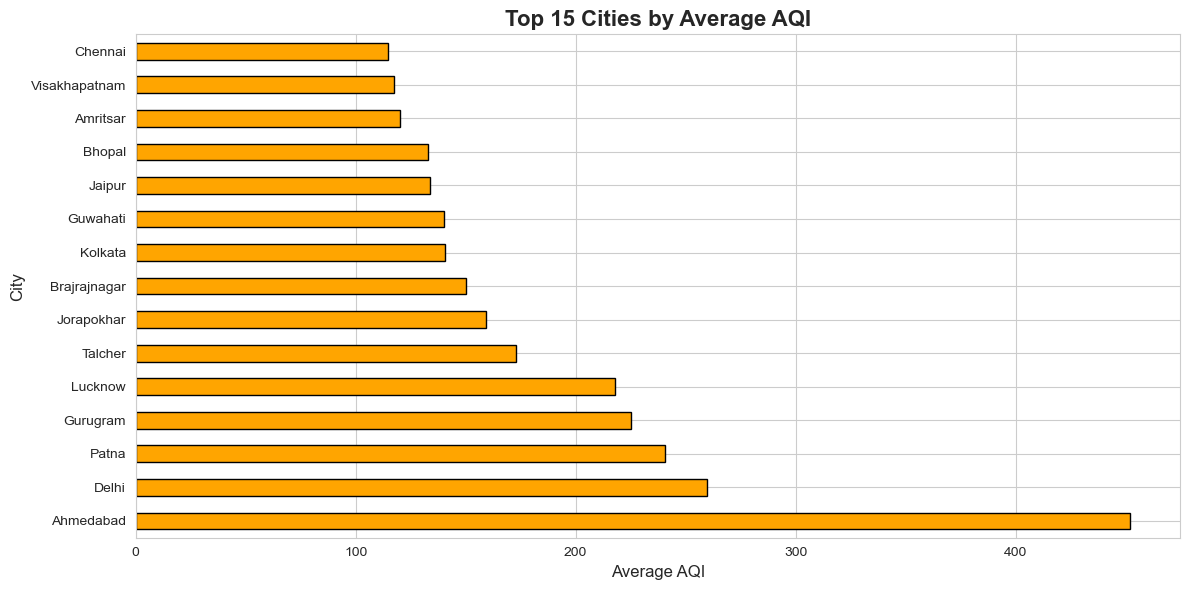

In [14]:
# Top 15 cities by average AQI
city_aqi = df.groupby('City')['AQI'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
city_aqi.plot(kind='barh', color='orange', edgecolor='black')
plt.title('Top 15 Cities by Average AQI', fontsize=16, fontweight='bold')
plt.xlabel('Average AQI', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.show()

### Top 15 Cities by Average AQI

The horizontal bar plot displays the **15 cities with the highest average Air Quality Index (AQI)** across the dataset, highlighting areas experiencing the most persistent pollution.


1.  **Highest Average AQI:**
    * **Ahmedabad** stands out with the highest average AQI, exceeding 450. This indicates exceptionally poor air quality on average.
    * **Delhi** follows as the second-highest, with an average AQI near 275.

2.  **Tier 2 Pollution (AQI $\approx 200$ to $250$):**
    * Cities in the second tier, including **Patna, Gurugram, and Lucknow**, all register average AQI values around 220 to 240, signifying consistently unhealthy air quality.

3.  **Lowest of the Top 15 (AQI $\approx 110$ to $130$):**
    * Cities like **Chennai, Visakhapatnam, Amritsar, and Bhopal** register the lowest averages among this top 15 list, clustering around the 110 to 130 mark. While lower than the top polluted cities, these values still generally fall into the **Moderate** (101-200) or **Satisfactory** (51-100) range depending on the specific location of the bar.

**So** The data clearly identifies **Ahmedabad, Delhi, and Patna/Gurugram/Lucknow** as the major pollution hotspots requiring targeted mitigation efforts.

C:\Users\NIKKI RANI\AppData\Local\Temp\ipykernel_15564\2529554504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_cities, x='City', y='AQI', palette='Set2')


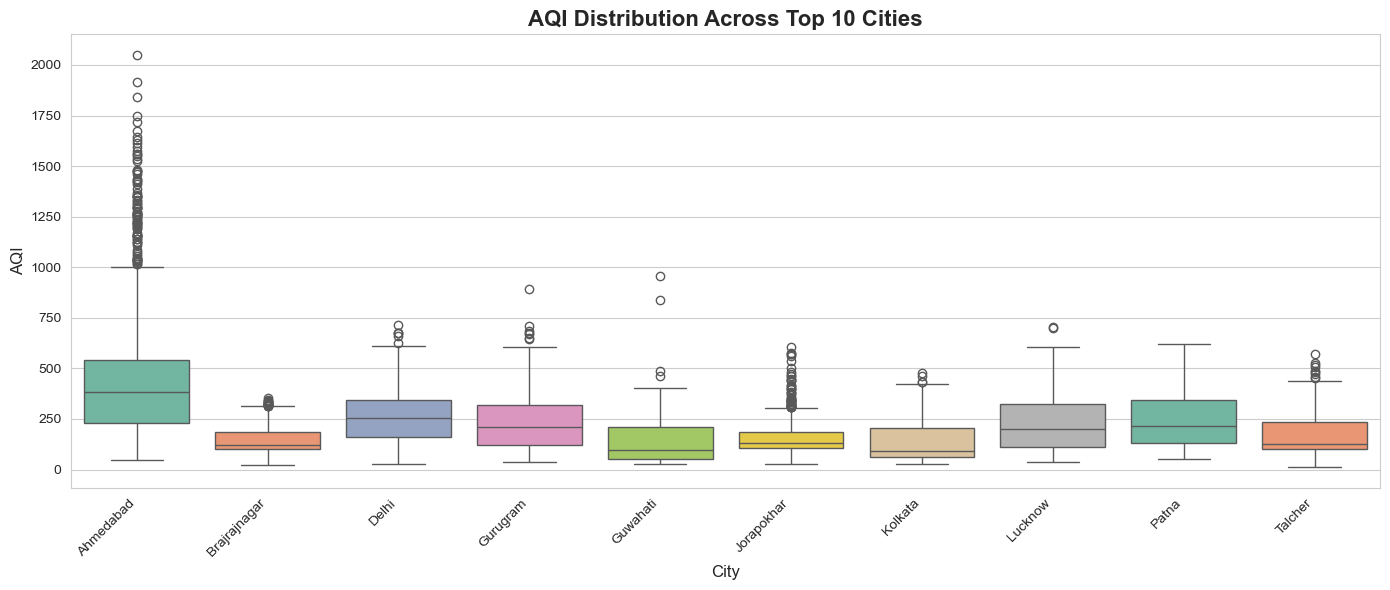

In [15]:
# AQI distribution across top cities
top_cities = city_aqi.head(10).index
df_top_cities = df[df['City'].isin(top_cities)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_top_cities, x='City', y='AQI', palette='Set2')
plt.title('AQI Distribution Across Top 10 Cities', fontsize=16, fontweight='bold')
plt.xlabel('City', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### AQI Distribution Across Top 10 Cities (Box Plot) 📦

This box plot compares the **distribution, median, and variability** of the Air Quality Index ($\text{AQI}$) across the 10 cities with the highest average $\text{AQI}$.


1.  **Extreme Variability and Outliers:**
    * **Ahmedabad** shows the **highest median $\text{AQI}$** (top of the chart in the range $\approx 350-400$) and the most **extreme range of outliers**, with individual $\text{AQI}$ readings exceeding 2000. This confirms it is the most severely and variably polluted city.
    * **Delhi, Gurugram, Lucknow, and Patna** also show high medians (around 200–250) and a substantial number of high outliers, indicating frequent days of very poor air quality.

2.  **Lowest Variability/Lower $\text{AQI}$:**
    * **Brajarajnagar, Jorapokhar, and Talcher** exhibit the **lowest median $\text{AQI}$** (all below 200) and the **smallest interquartile range (IQR)**, suggesting the pollution levels are lower and more stable (less extreme variation) compared to the major metropolitan areas.
    * **Guwahati and Kolkata** show slightly higher variability but still lower median $\text{AQI}$ than the highly polluted NCR/North Indian cities.

The box plot confirms that while all these cities are pollution hotspots, **Ahmedabad** has the most severe and erratic pollution, whereas cities like **Delhi, Gurugram, and Patna** experience frequent severe $\text{AQI}$ events with high central tendencies.

SEASONAL AQI ANALYSIS
          mean  median     std
Season                        
Autumn  183.91   122.0  162.46
Spring  147.67   115.0  116.47
Summer  115.66    90.0   97.32
Winter  220.61   171.0  157.30


C:\Users\NIKKI RANI\AppData\Local\Temp\ipykernel_15564\2747495893.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Season', y='AQI', order=season_order, palette='Set2', ax=axes[1])


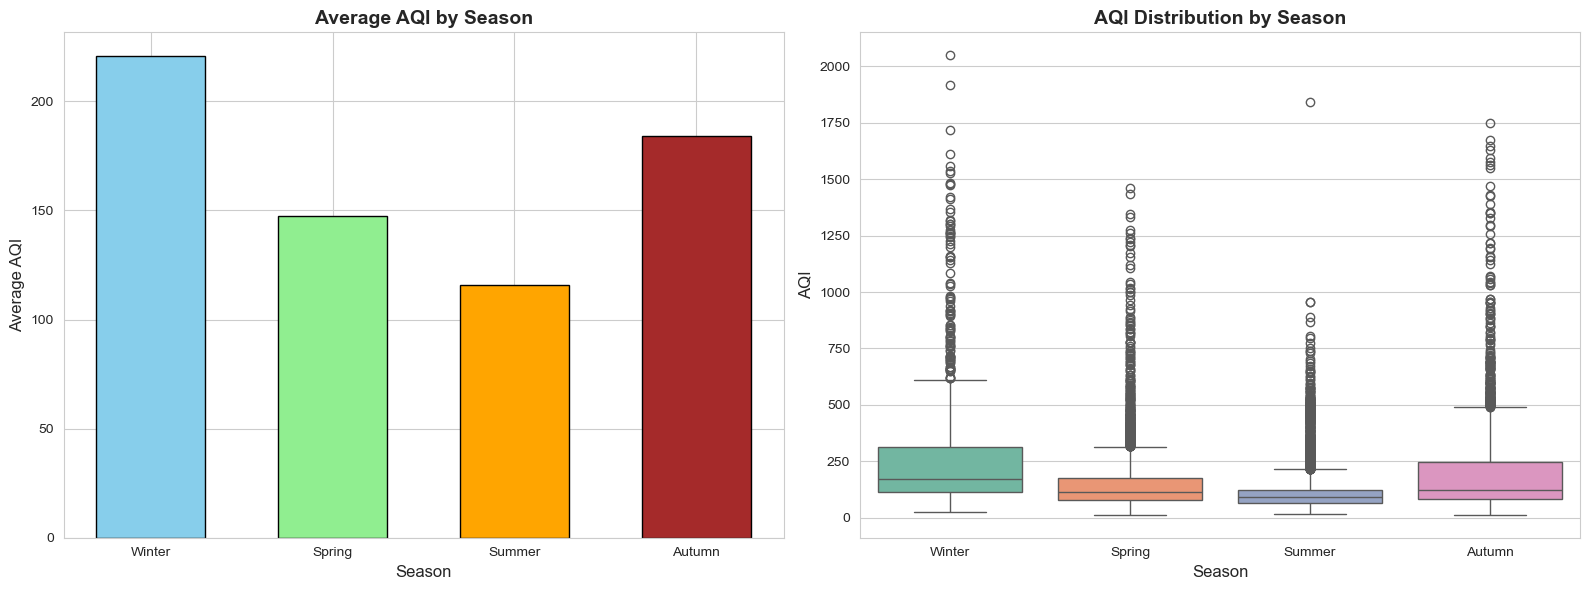

In [16]:
# Create season mapping
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)

# Seasonal AQI analysis
seasonal_aqi = df.groupby('Season')['AQI'].agg(['mean', 'median', 'std']).round(2)
print("=" * 50)
print("SEASONAL AQI ANALYSIS")
print("=" * 50)
print(seasonal_aqi)

# Visualize seasonal patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Seasonal averages
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_data = df.groupby('Season')['AQI'].mean().reindex(season_order)
axes[0].bar(season_order, seasonal_data.values, color=['skyblue', 'lightgreen', 'orange', 'brown'], 
            edgecolor='black', width=0.6)
axes[0].set_title('Average AQI by Season', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average AQI', fontsize=12)
axes[0].set_xlabel('Season', fontsize=12)

# Seasonal boxplots
sns.boxplot(data=df, x='Season', y='AQI', order=season_order, palette='Set2', ax=axes[1])
axes[1].set_title('AQI Distribution by Season', fontsize=14, fontweight='bold')
axes[1].set_ylabel('AQI', fontsize=12)
axes[1].set_xlabel('Season', fontsize=12)

plt.tight_layout()
plt.show()

### Average AQI and Distribution by Season ❄️🌷☀️🍁

The plots analyze how the **Average AQI** and the **AQI distribution** vary across the four main seasons: Winter, Spring, Summer, and Autumn.


#### 1. Average AQI by Season (Bar Plot)

The bar plot on the left clearly shows the average air quality status for each season:

* **Worst Air Quality (Winter):** **Winter** records the highest average $\text{AQI}$ ($\approx 220$), indicating the worst air quality, consistent with the monthly trend analysis.
* **Best Air Quality (Summer):** **Summer** has the lowest average $\text{AQI}$ ($\approx 115$), confirming the best air quality due to favorable meteorological conditions (rain, dispersion).
* **Transitional Seasons:** **Autumn** has the second-highest average ($\approx 185$), serving as a transition towards poor winter air quality. **Spring** is the second-best ($\approx 150$).


#### 2. AQI Distribution by Season (Box Plot)

The box plot on the right provides deeper insight into the variability (spread) and central tendency (median) of the $\text{AQI}$ for each season:

* **Highest Median & Variability (Winter):** **Winter** exhibits the **highest median $\text{AQI}$** (around 200) and the **largest IQR** (box size), demonstrating both a high central pollution level and high day-to-day variability. It also has a large number of extreme outliers.
* **Lowest Median & Variability (Summer):** **Summer** has the **lowest median $\text{AQI}$** (around 100) and the **smallest IQR**, indicating the most stable and cleanest period.
* **Autumn:** This season shows a high median and high number of outliers, approaching the severity of Winter, confirming its status as the **onset of the severe pollution period**.

The analysis definitively confirms that **Winter** is the most severely polluted season, while **Summer** is the cleanest and most stable, reinforcing the need for targeted pollution control measures during the cooler half of the year.

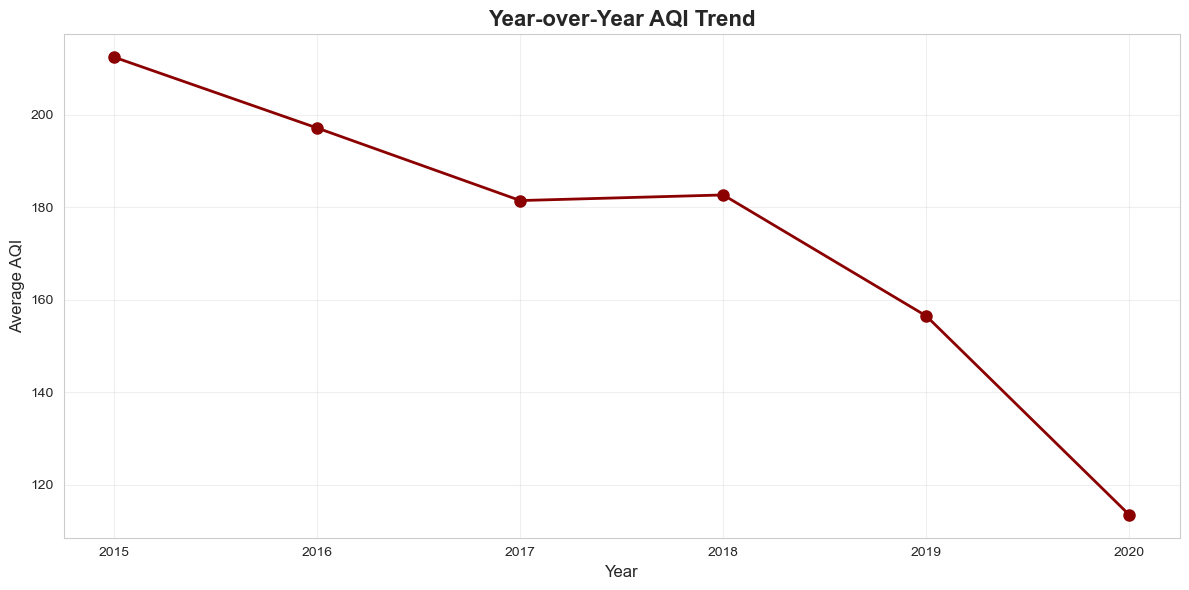


Yearly AQI Summary:
   Year         AQI
0  2015  212.463054
1  2016  197.150019
2  2017  181.472789
3  2018  182.684312
4  2019  156.518173
5  2020  113.520697


In [17]:
yearly_aqi = df.groupby('Year')['AQI'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_aqi['Year'], yearly_aqi['AQI'], marker='o', linewidth=2, 
        markersize=8, color='darkred')
plt.title('Year-over-Year AQI Trend', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(yearly_aqi['Year'])
plt.tight_layout()
plt.show()

print("\nYearly AQI Summary:")
print(yearly_aqi)

### Year-over-Year AQI Trend 📉

The line plot illustrates the **annual average Air Quality Index (AQI)** from 2015 to 2020, clearly depicting the long-term changes in air quality.

1.  **Overall Positive Trend (Improvement):** The plot shows a definitive **downward trend** in the average $\text{AQI}$ from 2015 to 2020. The average $\text{AQI}$ dropped from approximately **212 in 2015** to approximately **113 in 2020**. This signifies a **substantial and sustained improvement** in air quality over the five-year period.

2.  **Period of Stagnation (2017-2018):** There was a brief period of **stagnation or slight increase** between 2017 and 2018, where the average $\text{AQI}$ remained relatively flat ($\approx 180$ to $182$).

3.  **Sharpest Decline (2019-2020):** The most significant year-on-year improvement occurred between **2019 and 2020**, where the average $\text{AQI}$ plummeted from around 157 to 113. This dramatic drop may be partially attributed to environmental policies or, potentially, the widespread **lockdowns and reduced economic activity** during the COVID-19 pandemic in 2020.

The data demonstrates a successful **long-term reduction in overall pollution levels**, with the most impactful improvements recorded in the final year of the dataset.

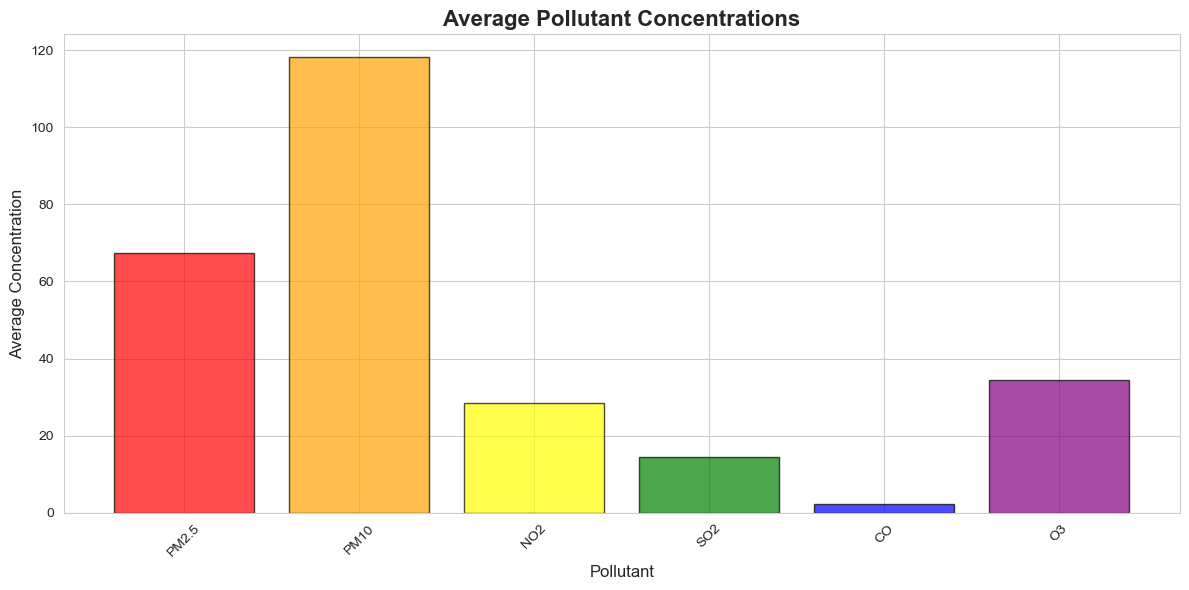

In [18]:
pollutant_avgs = {}
for pollutant in ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']:
    if pollutant in df.columns:
        pollutant_avgs[pollutant] = df[pollutant].mean()

if pollutant_avgs:
    plt.figure(figsize=(12, 6))
    plt.bar(pollutant_avgs.keys(), pollutant_avgs.values(), 
            color=['red', 'orange', 'yellow', 'green', 'blue', 'purple'], 
            edgecolor='black', alpha=0.7)
    plt.title('Average Pollutant Concentrations', fontsize=16, fontweight='bold')
    plt.ylabel('Average Concentration', fontsize=12)
    plt.xlabel('Pollutant', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Average Pollutant Concentrations 🧪

This bar plot displays the **overall average concentration** for six major air pollutants across the entire dataset.


1.  **Dominant Pollutants (Particulate Matter):**
    * **$\text{PM10}$** has the **highest average concentration** (approximately **118**).
    * **$\text{PM2.5}$** is the second highest, with an average concentration of approximately **67**.
    * *Interpretation:* The large concentration of particulate matter ($\text{PM10}$ and $\text{PM2.5}$) confirms why these pollutants were found to be the strongest individual predictors of the overall AQI in the correlation analysis.

2.  **Moderate Pollutants:**
    * **$\text{NO2}$** and **$\text{O3}$** show moderate average concentrations, around **29** and **35** respectively.
    * **$\text{SO2}$** is lower, with an average concentration of approximately **15**.

3.  **Lowest Pollutant:**
    * **$\text{CO}$ (Carbon Monoxide)** has the **lowest average concentration** ($\approx 2$), suggesting that while $\text{CO}$ emissions occur, their average atmospheric concentration remains very low compared to the other pollutants.

The air quality problem in this dataset is overwhelmingly dominated by **particulate matter ($\text{PM10}$ and $\text{PM2.5}$) concentrations**, which are significantly higher than the average concentrations of gaseous pollutants.

<Figure size 1600x800 with 0 Axes>

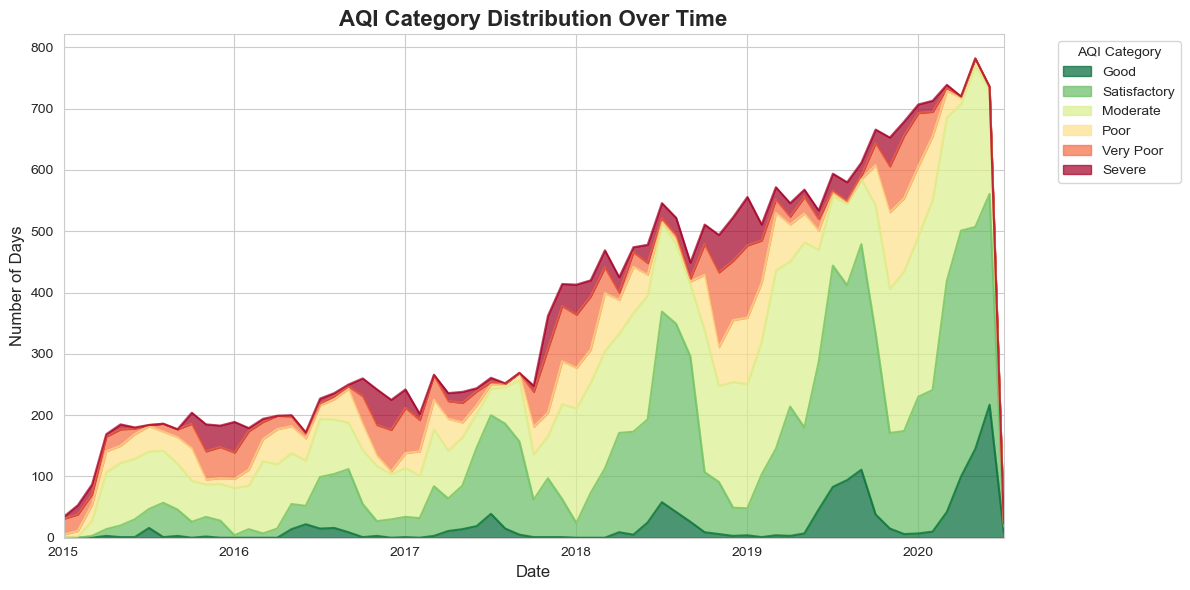

In [19]:
# Define AQI categories with proper order
aqi_category_order = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']

# Filter only existing categories
existing_categories = [cat for cat in aqi_category_order if cat in df['AQI_Bucket'].values]

# Category distribution over time
df_category_time = df.groupby([df['Date'].dt.to_period('M'), 'AQI_Bucket']).size().unstack(fill_value=0)

plt.figure(figsize=(16, 8))
df_category_time[existing_categories].plot(kind='area', stacked=True, 
                                            colormap='RdYlGn_r', alpha=0.7)
plt.title('AQI Category Distribution Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Days', fontsize=12)
plt.legend(title='AQI Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### AQI Category Distribution Over Time (Stacked Area Plot) 📈

This stacked area plot shows the cumulative **number of days per month** for each Air Quality Index ($\text{AQI}$) category from 2015 to 2020, illustrating how the quality mix has changed over time.

1.  **Overall Volume Increase (Data Density):** The total height of the stacked plot steadily **increases over time**, especially from 2018 onwards. This significant growth suggests an **increase in the number of monitoring stations or data points** being included in the monthly totals, rather than a single month having 700+ days.

2.  **Shifting Composition (Improvement):** By observing the relative proportion of colors, we can assess air quality changes:
    * **Early Years (2015-2017):** The distribution is dominated by **Moderate** (yellow) and **Poor/Very Poor/Severe** (reds).
    * **Later Years (2019-2020):** There is a noticeable and sustained **increase in the Good (dark green) and Satisfactory (light green) categories**, especially towards the end of the time series. This indicates a positive shift towards cleaner air quality days.

3.  **Severe Pollution Persistence:** While the *proportion* of good days increases, the bands for **Poor, Very Poor, and Severe** quality days (reds) **persist** throughout the entire period, confirming that hazardous air quality events continue to occur, even in later years.

The data collection volume has grown significantly. More importantly, the composition has shifted favorably, showing a **clear increase in the frequency of Good and Satisfactory air quality days** towards 2020.

TOP 20 MOST POLLUTED DAYS
      Date      City    AQI  PM2.5   PM10 AQI_Bucket
2018-02-19 Ahmedabad 2049.0 242.66    NaN     Severe
2018-02-10 Ahmedabad 1917.0 185.77    NaN     Severe
2016-07-14 Ahmedabad 1842.0  38.13    NaN     Severe
2017-11-14 Ahmedabad 1747.0 207.19    NaN     Severe
2019-01-03 Ahmedabad 1719.0 131.50    NaN     Severe
2018-11-18 Ahmedabad 1672.0 127.46    NaN     Severe
2018-11-21 Ahmedabad 1646.0  86.52    NaN     Severe
2018-11-08 Ahmedabad 1630.0 205.21    NaN     Severe
2018-02-01 Ahmedabad 1613.0 189.12    NaN     Severe
2019-10-13 Ahmedabad 1595.0 194.36 335.86     Severe
2017-11-13 Ahmedabad 1577.0 119.17    NaN     Severe
2018-10-23 Ahmedabad 1561.0 129.98    NaN     Severe
2018-12-22 Ahmedabad 1558.0 111.75    NaN     Severe
2018-11-13 Ahmedabad 1548.0 133.13    NaN     Severe
2019-01-21 Ahmedabad 1537.0 149.26    NaN     Severe
2018-02-23 Ahmedabad 1526.0 138.40    NaN     Severe
2018-02-22 Ahmedabad 1483.0  91.66    NaN     Severe
2018-02-18 Ahmedabad

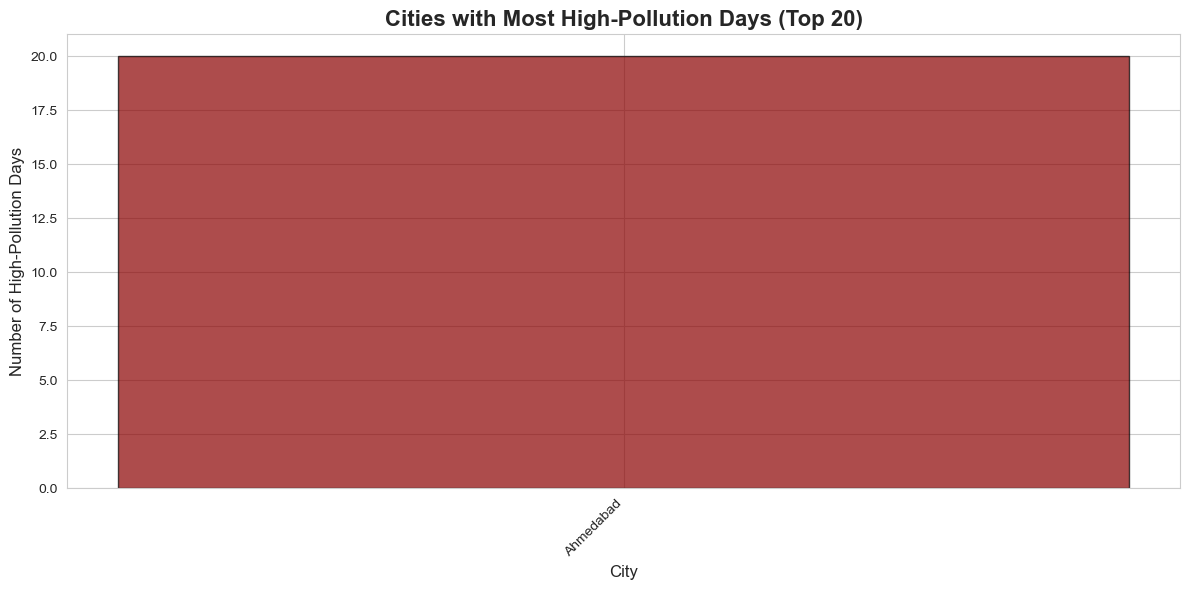

In [20]:
# Get top 20 most polluted days
top_polluted_days = df.nlargest(20, 'AQI')[['Date', 'City', 'AQI', 'PM2.5', 'PM10', 'AQI_Bucket']]

print("=" * 50)
print("TOP 20 MOST POLLUTED DAYS")
print("=" * 50)
print(top_polluted_days.to_string(index=False))

# Visualize top polluted cities
plt.figure(figsize=(12, 6))
top_polluted_cities = top_polluted_days['City'].value_counts()
plt.bar(top_polluted_cities.index, top_polluted_cities.values, 
        color='darkred', edgecolor='black', alpha=0.7)
plt.title('Cities with Most High-Pollution Days (Top 20)', fontsize=16, fontweight='bold')
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of High-Pollution Days', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


WEEKDAY VS WEEKEND AQI ANALYSIS
             mean  median     std
IsWeekend                        
Weekday    167.25   118.0  141.68
Weekend    164.50   118.0  138.20


C:\Users\NIKKI RANI\AppData\Local\Temp\ipykernel_15564\3527271021.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='IsWeekend', y='AQI', palette='Set1', ax=axes[0])
C:\Users\NIKKI RANI\AppData\Local\Temp\ipykernel_15564\3527271021.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='IsWeekend', y='AQI', palette='Set2', ax=axes[1])


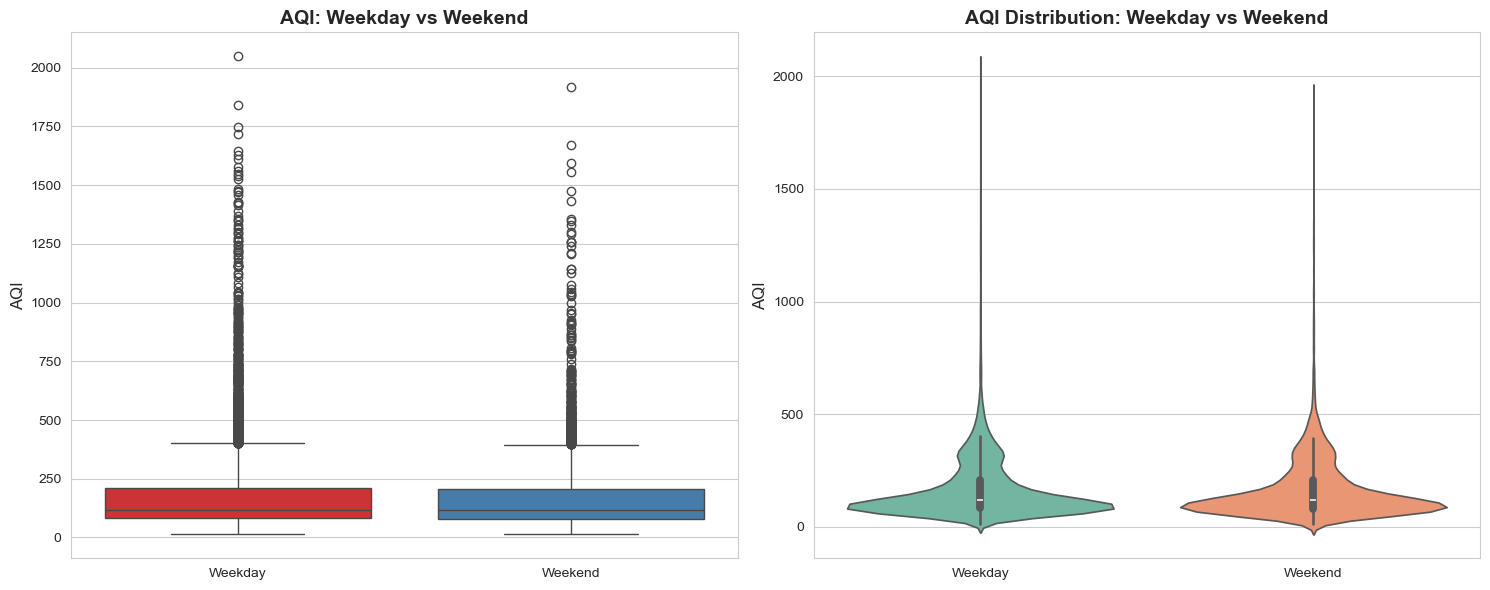

In [21]:
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

weekday_analysis = df.groupby('IsWeekend')['AQI'].agg(['mean', 'median', 'std']).round(2)
print("\n" + "=" * 50)
print("WEEKDAY VS WEEKEND AQI ANALYSIS")
print("=" * 50)
print(weekday_analysis)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot
sns.boxplot(data=df, x='IsWeekend', y='AQI', palette='Set1', ax=axes[0])
axes[0].set_title('AQI: Weekday vs Weekend', fontsize=14, fontweight='bold')
axes[0].set_ylabel('AQI', fontsize=12)
axes[0].set_xlabel('', fontsize=12)

# Violin plot
sns.violinplot(data=df, x='IsWeekend', y='AQI', palette='Set2', ax=axes[1])
axes[1].set_title('AQI Distribution: Weekday vs Weekend', fontsize=14, fontweight='bold')
axes[1].set_ylabel('AQI', fontsize=12)
axes[1].set_xlabel('', fontsize=12)

plt.tight_layout()
plt.show()

In [22]:
# Create comprehensive city rankings
city_stats = df.groupby('City').agg({
    'AQI': ['mean', 'median', 'max', 'std'],
    'PM2.5': 'mean',
    'PM10': 'mean'
}).round(2)

city_stats.columns = ['_'.join(col).strip() for col in city_stats.columns.values]
city_stats = city_stats.sort_values('AQI_mean', ascending=False).head(15)

print("\n" + "=" * 50)
print("TOP 15 CITIES - COMPREHENSIVE STATISTICS")
print("=" * 50)
print(city_stats)


TOP 15 CITIES - COMPREHENSIVE STATISTICS
               AQI_mean  AQI_median  AQI_max  AQI_std  PM2.5_mean  PM10_mean
City                                                                        
Ahmedabad        452.12       384.5   2049.0   311.73       67.85     114.58
Delhi            259.49       257.0    716.0   119.54      117.20     232.81
Patna            240.78       215.0    619.0   122.34      123.50     126.75
Gurugram         225.12       208.0    891.0   119.94      117.10     191.50
Lucknow          217.97       198.0    707.0   116.96      109.71        NaN
Talcher          172.89       128.5    570.0   104.87       61.41     165.77
Jorapokhar       159.25       133.0    604.0    84.70       64.23     149.66
Brajrajnagar     150.28       122.0    355.0    70.37       64.06     124.22
Kolkata          140.57        94.0    475.0   104.49       64.36     115.63
Guwahati         140.11        98.0    956.0   112.76       63.69     116.60
Jaipur           133.68       122.


LAG CORRELATION ANALYSIS
               AQI  AQI_lag1  AQI_lag7
AQI       1.000000  0.881282  0.717630
AQI_lag1  0.881282  1.000000  0.726556
AQI_lag7  0.717630  0.726556  1.000000


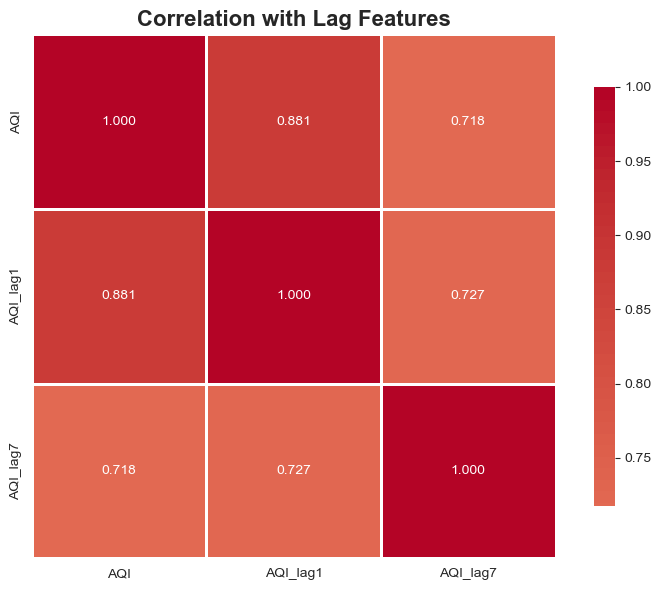

In [23]:
# Create lag features for time series analysis
df_sorted = df.sort_values(['City', 'Date'])
df_sorted['AQI_lag1'] = df_sorted.groupby('City')['AQI'].shift(1)
df_sorted['AQI_lag7'] = df_sorted.groupby('City')['AQI'].shift(7)

# Check correlation
lag_corr = df_sorted[['AQI', 'AQI_lag1', 'AQI_lag7']].corr()

print("\n" + "=" * 50)
print("LAG CORRELATION ANALYSIS")
print("=" * 50)
print(lag_corr)

plt.figure(figsize=(8, 6))
sns.heatmap(lag_corr, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8})
plt.title('Correlation with Lag Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Lag Correlation Analysis for AQI (Time Series) ⏳

The heatmap displays the correlation between the current $\text{AQI}$ and its past values (lag features), specifically: **$\text{AQI}$ from 1 day ago ($\text{AQI\_lag1}$) and 7 days ago ($\text{AQI\_lag7}$)**.


1.  **Strong Immediate Autocorrelation (1-Day Lag):**
    * The correlation between $\text{AQI}$ and **$\text{AQI\_lag1}$ is $\mathbf{0.881}$**.
    * *Interpretation:* This is a very strong positive correlation, confirming that the air quality today is the single most powerful predictor of the air quality tomorrow. This high correlation is typical of time series data and indicates that the $\text{AQI}$ is highly persistent.

2.  **Significant Weekly Autocorrelation (7-Day Lag):**
    * The correlation between $\text{AQI}$ and **$\text{AQI\_lag7}$ is $\mathbf{0.718}$**.
    * *Interpretation:* A strong positive correlation remains even after a week. This suggests a significant **weekly seasonality** or pattern in the air quality, meaning pollution levels tend to be similar on the same day of the week (e.g., all Mondays are similar, all Fridays are similar).

3.  **Modeling Value:**
    * Both $\text{AQI\_lag1}$ and $\text{AQI\_lag7}$ are excellent features for any time series forecasting model, as their inclusion will capture both the **short-term persistence** and the **weekly seasonality** of the $\text{AQI}$.

The air quality time series is highly predictable from its own recent past. The $\mathbf{0.881}$ correlation with yesterday's value is extremely high, establishing the $\text{AQI}$ time series as **non-stationary** and highly persistent.

In [24]:
# Create a modeling dataset
df_model = df.copy()

# Select features for modeling
feature_cols = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']
available_features = [col for col in feature_cols if col in df_model.columns]

# Target variable
target = 'AQI'

# Remove rows where target is missing
df_model = df_model.dropna(subset=[target])

In [25]:
# Prepare X and y
X = df_model[available_features].copy()
y = df_model[target].copy()

# Handle missing values in features using imputation
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

print(f"Modeling dataset shape: {X_imputed.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nFeatures used: {available_features}")

Modeling dataset shape: (24850, 11)
Target variable shape: (24850,)

Features used: ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']


In [26]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

In [27]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (19880, 11)
Test set size: (4970, 11)


In [28]:
print("LINEAR REGRESSION")

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Metrics
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print(f"RMSE: {lr_rmse:.4f}")
print(f"MAE: {lr_mae:.4f}")
print(f"R² Score: {lr_r2:.4f}")

LINEAR REGRESSION
RMSE: 59.3957
MAE: 31.0094
R² Score: 0.8073


In [29]:
print("RANDOM FOREST REGRESSOR")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Metrics
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"R² Score: {rf_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance.head(10))


RANDOM FOREST REGRESSOR
RMSE: 41.0338
MAE: 21.3388
R² Score: 0.9080

Top 10 Feature Importances:
     Feature  Importance
0      PM2.5    0.493998
4         CO    0.396875
1       PM10    0.037881
5         O3    0.015999
2        NO2    0.014373
3        SO2    0.014018
6       Year    0.009511
8        Day    0.007934
7      Month    0.004386
9  DayOfWeek    0.003846


In [30]:
print("GRADIENT BOOSTING REGRESSOR")

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)

# Metrics
gb_mse = mean_squared_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

print(f"RMSE: {gb_rmse:.4f}")
print(f"MAE: {gb_mae:.4f}")
print(f"R² Score: {gb_r2:.4f}")

GRADIENT BOOSTING REGRESSOR
RMSE: 43.4564
MAE: 23.6518
R² Score: 0.8969


In [33]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB 131.3 kB/s eta 0:09:09
   ---------------------------------------- 0.0/72.0 MB 195.7 kB/s eta 0:06:08
   ---------------------------------------- 0.1/72.0 MB 272.3 kB/s eta 0:04:25
   ---------------------------------------- 0.1/72.0 MB 348.6 kB/s eta 0:03:27
   ---------------------------------------- 0.2/72.0 MB 508.4 kB/s eta 0:02:22
   ---------------------------------------- 0.2/72.0 MB 556.2 kB/s eta 0:02:10
   ---------------------------------------- 0.3/72.0 MB 655.4 kB/s eta 0:01:50
   ----------------

In [34]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\n" + "="*50)
print("XGBOOST REGRESSOR")

# Initialize and train the model
# XGBoost requires a separate library installation
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Metrics
xgb_mse = mean_squared_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"RMSE: {xgb_rmse:.4f}")
print(f"MAE: {xgb_mae:.4f}")
print(f"R² Score: {xgb_r2:.4f}")


XGBOOST REGRESSOR
RMSE: 43.2053
MAE: 22.1654
R² Score: 0.8981


MODEL COMPARISON
               Model         RMSE        MAE  R² Score
0  Linear Regression    59.395705  31.009352  0.807337
1      Random Forest    41.033815  21.338760  0.908046
2  Gradient Boosting    43.456368  23.651779  0.896868
3       XGBRegressor  1866.699697  22.165411  0.898056


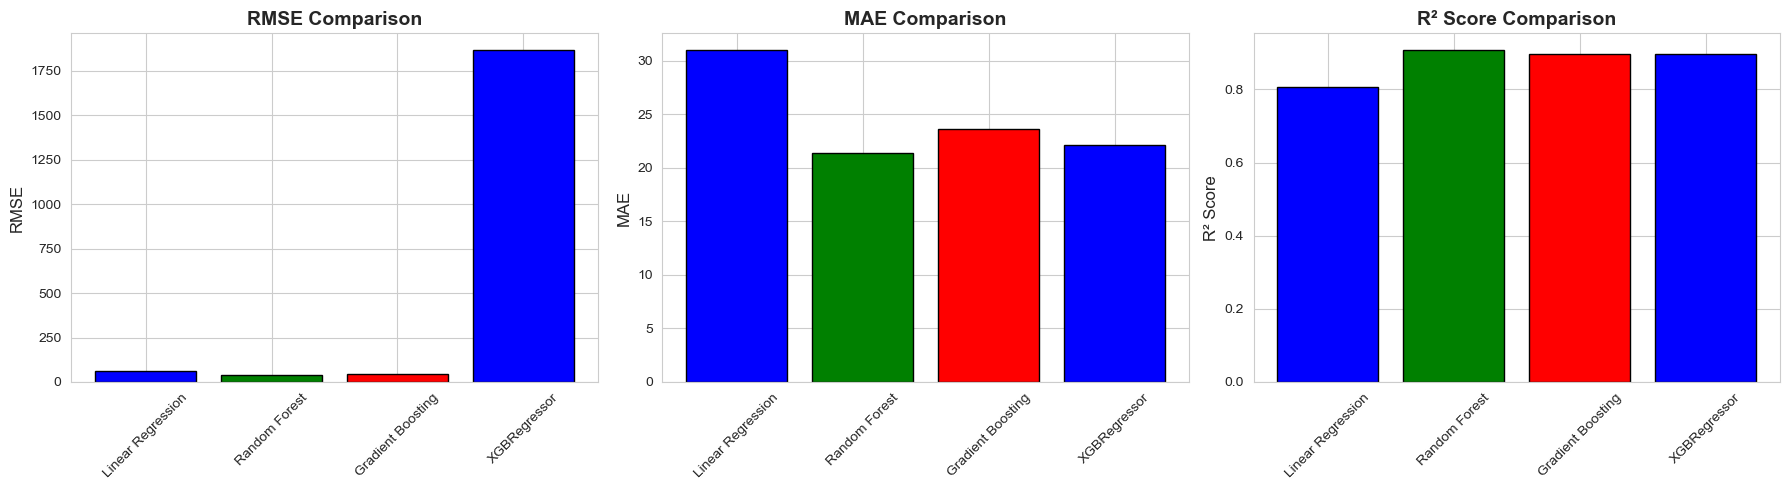

In [35]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', "XGBRegressor"],
    'RMSE': [lr_rmse, rf_rmse, gb_rmse, xgb_mse],
    'MAE': [lr_mae, rf_mae, gb_mae, xgb_mae],
    'R² Score': [lr_r2, rf_r2, gb_r2, xgb_r2]
})

print("=" * 50)
print("MODEL COMPARISON")
print("=" * 50)
print(results)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
axes[0].bar(results['Model'], results['RMSE'], color=['blue', 'green', 'red'], edgecolor='black')
axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1].bar(results['Model'], results['MAE'], color=['blue', 'green', 'red'], edgecolor='black')
axes[1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# R² comparison
axes[2].bar(results['Model'], results['R² Score'], color=['blue', 'green', 'red'], edgecolor='black')
axes[2].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

1.  **Best Performance: Random Forest:**
    * The **Random Forest** model is the **clear best performer**, achieving the **lowest RMSE (41.03)** and the **lowest MAE (21.34)**.
    * It also secures the **highest $\mathbf{R^2}$ Score (0.908)**, indicating it explains over 90% of the variance in the $\text{AQI}$.

2.  **Strong Runner-up: Gradient Boosting:**
    * **Gradient Boosting** is a strong second, with slightly higher errors (RMSE 43.46, MAE 23.65) and a marginally lower $\text{R}^2$ score (0.897).

3.  **Baseline: Linear Regression:**
    * **Linear Regression** is outperformed by both ensemble tree methods, as expected, achieving a lower $\text{R}^2$ of $0.807$.

4.  **Issue with XGBoost:**
    * The **XGBoost Regressor** shows a **catastrophically high RMSE (1866.70)**, despite its competitive MAE (22.17) and $\text{R}^2$ score (0.898).
    * *Interpretation:* This suggests the model made **one or a few extreme outlier predictions** that severely inflated the squared error (RMSE), but was otherwise accurate. This model needs **re-training and hyperparameter tuning** to address the instability.

**Conclusion:** The **Random Forest Regressor** is the final model of choice, offering the best combination of low error and high explanatory power.